**Expedia is interested in predicting which hotel group a user is going to book. Expedia uses algorithms to form hotel clusters, where similar hotels are grouped together. These clusters are based on historical price, customer star ratings, geographical locations relative to city center, etc. These hotel clusters serve as good identifiers to which types of hotels people are going to book, while avoiding outliers such as new hotels that don't have historical data.**

**In this competition, the goal is to predict the booking outcome (hotel cluster) for a user event, based on their search and other attributes associated with that user event.**

First of all we import packages required for this competition. We also import the different datasets.

In [2]:
###import packages 
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.cbook as cbook

import pandas as pd
import numpy as np
import plotly as py
import plotly.graph_objs as go

import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt

from sklearn.preprocessing import scale
from sklearn.decomposition import PCA



###import data 
df_train = pd.read_csv(r'C:\Users\tfrancois\Documents\Personal\kaggle\train.csv')
df_test = pd.read_csv(r'C:\Users\tfrancois\Documents\Personal\kaggle\test.csv')
df_dest = pd.read_csv(r'C:\Users\tfrancois\Documents\Personal\kaggle\destinations.csv')





The overall dastaset is way to big to be handled by the RAM of my computer. Therefore we only keep the booking records and remove all clicks that did not lead to a reservation. We also use a random function to only select 10,000 users. 

In [3]:
#keep booking records
df_train = df_train[df_train['is_booking'] == 1] 

#select 10,000 users
import random
unique_users = set(df_train.user_id.unique())
rand_user_id = random.sample(unique_users,10000)


df_train = pd.DataFrame()
train_chunk = pd.read_csv('train.csv', iterator = True, chunksize = 1000000)
for chunk in train_chunk:
    df_train = df_train.append(chunk.loc[chunk['user_id'].isin(rand_user_id)])
    
#check we have our 10,000 users
df_train['user_id'].nunique()

10000

Let's start exploratory analysis. We bar chart a few critical features and see how they relate to the target hotel_cluster

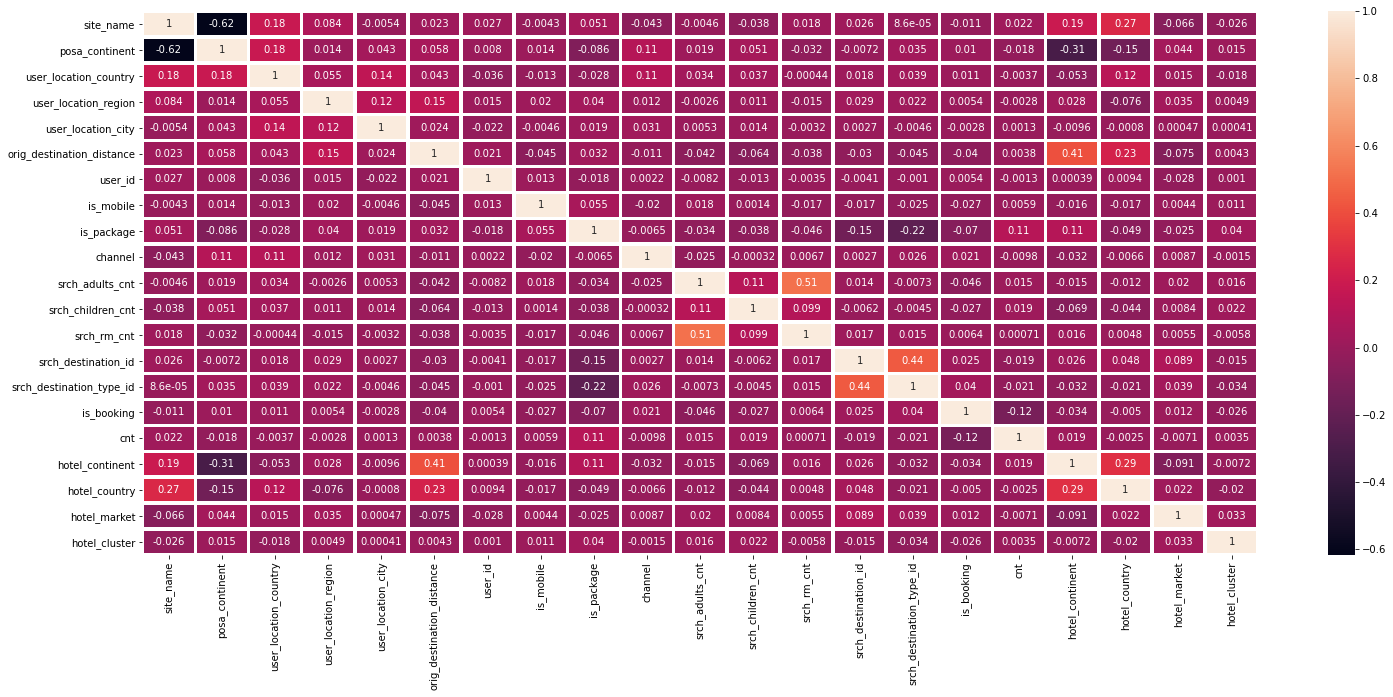

In [4]:
###exploratory analysis 

#columns
df_train.columns

#time 
df_train['date_time'].describe()

#we want to histogram a few columns where the number of values is limited
for col in ['site_name','posa_continent','user_location_country','is_mobile','srch_adults_cnt','srch_children_cnt','srch_rm_cnt','hotel_continent','hotel_country','hotel_cluster']:

    

    df_hotel_cluster = df_train.groupby(by=[col]).count()['user_id'].reset_index()

    py.offline.init_notebook_mode(connected=True)

    trace1 = go.Bar(
        x= df_hotel_cluster[col],
        y= df_hotel_cluster['user_id'],
        name='Histogram')

    data = trace1
    
    layout = go.Layout(
        barmode='group',
        showlegend=False,
        title='histogram',
        yaxis=dict(
        title='count'
        ),
        xaxis=dict(
        title= col
        )
    )

    fig = go.Figure(data=data, layout=layout)
    py.offline.iplot(fig)

#correlation matrix 
corrMatrix = df_train.corr()
plt.figure(figsize = (25,10))
sn.heatmap(corrMatrix, annot=True, linewidths=2.5)
plt.show()

In [5]:
#convert datetime to date
df_train['date'] = pd.to_datetime(df_train['date_time']).dt.date

#histogram of search date
for col in ['date']:

    
    df_hotel_cluster = df_train.groupby(by=[col]).count()['user_id'].reset_index()

    py.offline.init_notebook_mode(connected=True)

    trace1 = go.Bar(
        x= df_hotel_cluster[col],
        y= df_hotel_cluster['user_id'],
        name='Histogram')

    data = trace1
    
    layout = go.Layout(
        barmode='group',
        showlegend=False,
        title='histogram',
        yaxis=dict(
        title='count'
        ),
        xaxis=dict(
        title= col
        )
    )

    fig = go.Figure(data=data, layout=layout)
    py.offline.iplot(fig)

In [6]:
#check in and check out 
for col in ['srch_ci','srch_co']:

    
    df_hotel_cluster = df_train.groupby(by=[col]).count()['user_id'].reset_index()

    py.offline.init_notebook_mode(connected=True)

    trace1 = go.Bar(
        x= df_hotel_cluster[col],
        y= df_hotel_cluster['user_id'],
        name='Histogram')

    data = trace1
    
    layout = go.Layout(
        barmode='group',
        showlegend=False,
        title='histogram',
        yaxis=dict(
        title='count'
        ),
        xaxis=dict(
        title= col
        )
    )

    fig = go.Figure(data=data, layout=layout)
    py.offline.iplot(fig)

We want to understand the booking frequency among users. We also want to see if the users who made more than one reservation are more likely to book a specific cluster of hotel.

Text(0.5, 0, 'Data')

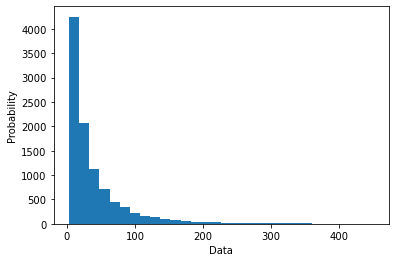

In [11]:
#understand bookings per user (want to know if some users have booked hotels more than others in the training data)
df_user_booking_count = df_train.groupby(by=['user_id']).count()['hotel_cluster'].reset_index()

df_user_booking_count = df_user_booking_count.rename(columns={"hotel_cluster": "booking_count"})

x = df_user_booking_count['booking_count']

#usually how you determine length of a bin - here q25 = q75 so bin_width = 0
#q25, q75 = np.percentile(x, [0.25, 0.75])
#bin_width = 2 * (q75 - q25) * len(x) ** (-1/3)
#bins = round((x.max() - x.min()) / bin_width)
#print("Freedman–Diaconis number of bins:", bins)

plt.hist(x, density=False, bins= 30)  # density= false would make counts
plt.ylabel('Number of users')
plt.xlabel('Number of bookings')



In [21]:
#this graph does not do what it was supposed to do ... 

df_train_2 = pd.merge(df_train, df_user_booking_count, on="user_id", how="left")

from pandasql import sqldf

pysqldf = lambda q: sqldf(q, globals())

q = """SELECT DISTINCT hotel_cluster,user_id,booking_count 
       FROM df_train_2;"""

df_stack = pysqldf(q)



#stack - first df only looks at users who booked once
df_stackbar1 = df_stack[df_stack['booking_count'] == 1].groupby(by=['hotel_cluster']).count()['user_id'].reset_index()
df_stackbar2 = df_stack[df_stack['booking_count'] == 2].groupby(by=['hotel_cluster']).count()['user_id'].reset_index()
df_stackbar3 = df_stack[df_stack['booking_count'] == 3].groupby(by=['hotel_cluster']).count()['user_id'].reset_index()
df_stackbar4 = df_stack[df_stack['booking_count'] == 4].groupby(by=['hotel_cluster']).count()['user_id'].reset_index()
df_stackbar5 = df_stack[df_stack['booking_count'] == 5].groupby(by=['hotel_cluster']).count()['user_id'].reset_index()
df_stackbar6 = df_stack[df_stack['booking_count'] >= 6].groupby(by=['hotel_cluster']).count()['user_id'].reset_index()

trace1 = go.Bar(
    x= df_stackbar1['hotel_cluster'],
    y= df_stackbar1['user_id'],
    name='1'
)

trace2= go.Bar(
    x= df_stackbar2['hotel_cluster'],
    y= df_stackbar2['user_id'],
    name='2'
)

trace3 = go.Bar(
    x= df_stackbar3['hotel_cluster'],
    y= df_stackbar3['user_id'],
    name='3'
)

trace4= go.Bar(
    x= df_stackbar4['hotel_cluster'],
    y= df_stackbar4['user_id'],
    name='4'
)

trace5 = go.Bar(
    x= df_stackbar5['hotel_cluster'],
    y= df_stackbar5['user_id'],
    name='5'
)

trace6 = go.Bar(
    x= df_stackbar5['hotel_cluster'],
    y= df_stackbar5['user_id'],
    name='6'
)



data = [trace1,trace2,trace3,trace4,trace5,trace6]
layout = go.Layout(
    barmode='stack',
    title='User count by hotel cluster',
    yaxis=dict(
    title='User Count'
    ),
    xaxis=dict(
    title='Hotel Cluster')
)

fig = go.Figure(data=data, layout=layout)
py.offline.iplot(fig)



Now we want to see if some cluster hotels are more booked during certain months of the year.

In [22]:

df_train_2['month'] = pd.DatetimeIndex(df_train_2['date_time']).month


df_stackbar1 = df_train_2[df_train_2['month'] == 1].groupby(by=['hotel_cluster']).count()['user_id'].reset_index()
df_stackbar2 = df_train_2[df_train_2['month'] == 2].groupby(by=['hotel_cluster']).count()['user_id'].reset_index()
df_stackbar3 = df_train_2[df_train_2['month'] == 3].groupby(by=['hotel_cluster']).count()['user_id'].reset_index()
df_stackbar4 = df_train_2[df_train_2['month'] == 4].groupby(by=['hotel_cluster']).count()['user_id'].reset_index()
df_stackbar5 = df_train_2[df_train_2['month'] == 5].groupby(by=['hotel_cluster']).count()['user_id'].reset_index()
df_stackbar6 = df_train_2[df_train_2['month'] == 6].groupby(by=['hotel_cluster']).count()['user_id'].reset_index()
df_stackbar7 = df_train_2[df_train_2['month'] == 7].groupby(by=['hotel_cluster']).count()['user_id'].reset_index()
df_stackbar8 = df_train_2[df_train_2['month'] == 8].groupby(by=['hotel_cluster']).count()['user_id'].reset_index()
df_stackbar9 = df_train_2[df_train_2['month'] == 9].groupby(by=['hotel_cluster']).count()['user_id'].reset_index()
df_stackbar10 = df_train_2[df_train_2['month'] == 10].groupby(by=['hotel_cluster']).count()['user_id'].reset_index()
df_stackbar11 = df_train_2[df_train_2['month'] == 11].groupby(by=['hotel_cluster']).count()['user_id'].reset_index()
df_stackbar12 = df_train_2[df_train_2['month'] == 12].groupby(by=['hotel_cluster']).count()['user_id'].reset_index()

In [23]:
#stack - month of search


trace1 = go.Bar(
    x= df_stackbar1['hotel_cluster'],
    y= df_stackbar1['user_id'],
    name='1'
)

trace2= go.Bar(
    x= df_stackbar2['hotel_cluster'],
    y= df_stackbar2['user_id'],
    name='2'
)

trace3 = go.Bar(
    x= df_stackbar3['hotel_cluster'],
    y= df_stackbar3['user_id'],
    name='3'
)

trace4= go.Bar(
    x= df_stackbar4['hotel_cluster'],
    y= df_stackbar4['user_id'],
    name='4'
)

trace5 = go.Bar(
    x= df_stackbar5['hotel_cluster'],
    y= df_stackbar5['user_id'],
    name='5'
)

trace6 = go.Bar(
    x= df_stackbar5['hotel_cluster'],
    y= df_stackbar5['user_id'],
    name='6'
)

trace7 = go.Bar(
    x= df_stackbar5['hotel_cluster'],
    y= df_stackbar5['user_id'],
    name='7'
)

trace8 = go.Bar(
    x= df_stackbar5['hotel_cluster'],
    y= df_stackbar5['user_id'],
    name='8'
)

trace9 = go.Bar(
    x= df_stackbar5['hotel_cluster'],
    y= df_stackbar5['user_id'],
    name='9'
)

trace10 = go.Bar(
    x= df_stackbar5['hotel_cluster'],
    y= df_stackbar5['user_id'],
    name='10'
)

trace11 = go.Bar(
    x= df_stackbar5['hotel_cluster'],
    y= df_stackbar5['user_id'],
    name='11'
)

trace12 = go.Bar(
    x= df_stackbar5['hotel_cluster'],
    y= df_stackbar5['user_id'],
    name='12'
)




data = [trace1,trace2,trace3,trace4,trace5,trace6,trace7,trace8,trace9,trace10,trace11,trace12]
layout = go.Layout(
    barmode='stack',
    title='Booking Count By Month',
    yaxis=dict(
    title='Booking Count'
    ),
    xaxis=dict(
    title='Hotel Cluster')
)

fig = go.Figure(data=data, layout=layout)
py.offline.iplot(fig)


Let's now see if there is a correlation between search destination type and clusters

In [24]:
#type of search destination 

df_stackbar1 = df_train_2[df_train_2['srch_destination_type_id'] == 1].groupby(by=['hotel_cluster']).count()['user_id'].reset_index()
df_stackbar2 = df_train_2[df_train_2['srch_destination_type_id'] == 2].groupby(by=['hotel_cluster']).count()['user_id'].reset_index()
df_stackbar3 = df_train_2[df_train_2['srch_destination_type_id'] == 3].groupby(by=['hotel_cluster']).count()['user_id'].reset_index()
df_stackbar4 = df_train_2[df_train_2['srch_destination_type_id'] == 4].groupby(by=['hotel_cluster']).count()['user_id'].reset_index()
df_stackbar5 = df_train_2[df_train_2['srch_destination_type_id'] == 5].groupby(by=['hotel_cluster']).count()['user_id'].reset_index()
df_stackbar6 = df_train_2[df_train_2['srch_destination_type_id'] == 6].groupby(by=['hotel_cluster']).count()['user_id'].reset_index()
df_stackbar7 = df_train_2[df_train_2['srch_destination_type_id'] == 7].groupby(by=['hotel_cluster']).count()['user_id'].reset_index()
df_stackbar8 = df_train_2[df_train_2['srch_destination_type_id'] == 8].groupby(by=['hotel_cluster']).count()['user_id'].reset_index()
df_stackbar9 = df_train_2[df_train_2['srch_destination_type_id'] == 9].groupby(by=['hotel_cluster']).count()['user_id'].reset_index()


In [25]:
#stack - type of search destination 


trace1 = go.Bar(
    x= df_stackbar1['hotel_cluster'],
    y= df_stackbar1['user_id'],
    name='1'
)

trace2= go.Bar(
    x= df_stackbar2['hotel_cluster'],
    y= df_stackbar2['user_id'],
    name='2'
)

trace3 = go.Bar(
    x= df_stackbar3['hotel_cluster'],
    y= df_stackbar3['user_id'],
    name='3'
)

trace4= go.Bar(
    x= df_stackbar4['hotel_cluster'],
    y= df_stackbar4['user_id'],
    name='4'
)

trace5 = go.Bar(
    x= df_stackbar5['hotel_cluster'],
    y= df_stackbar5['user_id'],
    name='5'
)

trace6 = go.Bar(
    x= df_stackbar5['hotel_cluster'],
    y= df_stackbar5['user_id'],
    name='6'
)

trace7 = go.Bar(
    x= df_stackbar5['hotel_cluster'],
    y= df_stackbar5['user_id'],
    name='7'
)

trace8 = go.Bar(
    x= df_stackbar5['hotel_cluster'],
    y= df_stackbar5['user_id'],
    name='8'
)

trace9 = go.Bar(
    x= df_stackbar5['hotel_cluster'],
    y= df_stackbar5['user_id'],
    name='9'
)




data = [trace1,trace2,trace3,trace4,trace5,trace6,trace7,trace8,trace9]
layout = go.Layout(
    barmode='stack',
    title='Search Count By Search Type',
    yaxis=dict(
    title='Search Count'
    ),
    xaxis=dict(
    title='Hotel Cluster')
)

fig = go.Figure(data=data, layout=layout)
py.offline.iplot(fig)


In [26]:
print(len(df_train_2['hotel_market'].unique()))
print(len(df_train_2['hotel_country'].unique()))

1918
185


Let's now analyze the count of bookings vs duration of the stay.

<AxesSubplot:xlabel='duration'>

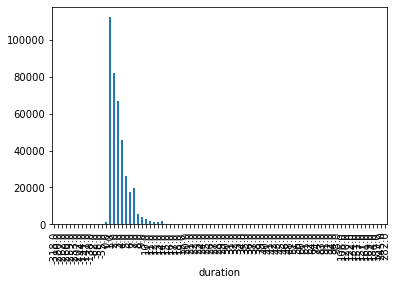

In [30]:
#duration of a stay 
df_train_2['srch_co'] = pd.to_datetime(df_train_2['srch_co'])
df_train_2['srch_ci'] = pd.to_datetime(df_train_2['srch_ci'])
df_train_2['duration'] = df_train_2['srch_co'] - df_train_2['srch_ci']

df_train_2['duration'] = df_train_2['duration']/np.timedelta64(1,'D')

df_train_2.groupby('duration').count()['user_id'].plot.bar()




The destination dataset has hundreds of features. Most of them are probably not needed. We are going to use PCA to reduce the dimensionality of the dataset and only keep the features that represent ~ 2/3 of the data.

In [32]:
#use PCA to reduce dim of the dest dataset 
from sklearn.decomposition import PCA

#standardize dataset 
x = df_dest.values #convert the data into a numpy array
x = scale(x);x

#covariance matrix with the 150 features
covar_matrix = PCA(n_components=150)
covar_matrix.fit(x)
#calculate variance ratios
variance = covar_matrix.explained_variance_ratio_ 
#cumulative sum of variance explained with [n] features
var=np.cumsum(np.round(covar_matrix.explained_variance_ratio_, decimals=3)*100)
print(var) 

#the first 8 eigenvalues represents 66% of the variance in the data
pca = PCA(n_components= 8)
dest_small = pca.fit_transform(df_dest[["d{0}".format(i + 1) for i in range(149)]])
dest_small = pd.DataFrame(dest_small)
dest_small["srch_destination_id"] = df_dest["srch_destination_id"]



[51.1 56.6 59.4 61.7 63.3 64.7 65.8 66.8 67.7 68.5 69.3 70.1 70.8 71.5
 72.2 72.9 73.5 74.1 74.7 75.3 75.9 76.5 77.  77.5 78.  78.5 79.  79.5
 80.  80.4 80.8 81.2 81.6 82.  82.4 82.8 83.2 83.6 84.  84.4 84.7 85.
 85.3 85.6 85.9 86.2 86.5 86.8 87.1 87.4 87.7 88.  88.3 88.6 88.9 89.2
 89.5 89.8 90.1 90.3 90.5 90.7 90.9 91.1 91.3 91.5 91.7 91.9 92.1 92.3
 92.5 92.7 92.9 93.1 93.3 93.5 93.7 93.9 94.1 94.3 94.5 94.7 94.9 95.1
 95.3 95.5 95.7 95.9 96.  96.1 96.2 96.3 96.4 96.5 96.6 96.7 96.8 96.9
 97.  97.1 97.2 97.3 97.4 97.5 97.6 97.7 97.8 97.9 98.  98.1 98.2 98.3
 98.4 98.5 98.6 98.7 98.8 98.9 99.  99.1 99.2 99.3 99.4 99.5 99.5 99.5
 99.5 99.5 99.5 99.5 99.5 99.5 99.5 99.5 99.5 99.5 99.5 99.5 99.5 99.5
 99.5 99.5 99.5 99.5 99.5 99.5 99.5 99.5 99.5 99.5]


In [21]:
dest_small.head()
dest_small.describe()

,0,1,2,3,4,5,6,7,srch_destination_id
count,6.210600e+04,6.210600e+04,6.210600e+04,6.210600e+04,6.210600e+04,6.210600e+04,6.210600e+04,6.210600e+04,62106.000000
mean,-3.223027e-16,-3.331397e-16,-1.835577e-16,2.423029e-16,3.160976e-16,-6.921453e-17,-2.493308e-17,-4.766548e-17,32359.463884
std,5.218142e-01,2.529521e-01,1.653930e-01,1.217086e-01,1.175144e-01,1.120834e-01,9.995317e-02,9.459436e-02,18711.765765
min,-6.101911e-01,-8.273612e-01,-8.966624e-01,-5.307322e-01,-5.244980e-01,-5.027911e-01,-4.476472e-01,-6.130289e-01,0.000000
25%,-4.273949e-01,-1.054172e-01,-6.759648e-02,-5.735178e-02,-6.122263e-02,-5.638467e-02,-4.663594e-02,-4.702855e-02,16320.250000
50%,-1.358665e-01,-3.215461e-02,-1.501543e-02,-1.764032e-02,-7.137245e-03,7.625603e-03,9.111882e-03,5.409911e-03,32277.500000
75%,3.008873e-01,1.504895e-02,8.047973e-02,6.061724e-02,3.552097e-02,4.977892e-02,3.985461e-02,3.765695e-02,48467.750000
max,3.669258e+00,2.326228e+00,1.097049e+00,8.771733e-01,1.051895e+00,1.111884e+00,1.023937e+00,1.617139e+00,64993.000000


We need to feature engineering some of the columns. The idea of this below cell is to convert datetime to year, month and week.

In [52]:
df_train_3 = pd.merge(df_train_2, dest_small, on="srch_destination_id", how="left")

df_train_3['year'] = pd.DatetimeIndex(df_train_2['date_time']).year
df_train_3['month'] = pd.DatetimeIndex(df_train_2['date_time']).month
df_train_3['week'] = pd.DatetimeIndex(df_train_2['date_time']).week

df_train_3['srch_ci_month'] = pd.DatetimeIndex(df_train_2['srch_ci']).month
df_train_3['srch_ci_week'] = pd.DatetimeIndex(df_train_2['srch_ci']).week

df_train_3['srch_co_month'] = pd.DatetimeIndex(df_train_2['srch_co']).month
df_train_3['srch_co_week'] = pd.DatetimeIndex(df_train_2['srch_co']).week





<ipython-input-52-ded2473dc351>:5: FutureWarning:

weekofyear and week have been deprecated, please use DatetimeIndex.isocalendar().week instead, which returns a Series.  To exactly reproduce the behavior of week and weekofyear and return an Index, you may call pd.Int64Index(idx.isocalendar().week)

<ipython-input-52-ded2473dc351>:8: FutureWarning:

weekofyear and week have been deprecated, please use DatetimeIndex.isocalendar().week instead, which returns a Series.  To exactly reproduce the behavior of week and weekofyear and return an Index, you may call pd.Int64Index(idx.isocalendar().week)

<ipython-input-52-ded2473dc351>:11: FutureWarning:

weekofyear and week have been deprecated, please use DatetimeIndex.isocalendar().week instead, which returns a Series.  To exactly reproduce the behavior of week and weekofyear and return an Index, you may call pd.Int64Index(idx.isocalendar().week)



This is the second part of features engineering. We use sinus/cosinus function to reflect month/week seasonality. We also separate categorical vs continous features.

In [53]:


df_train_3 = df_train_3.rename(
    columns={"1": "dest_feature_1","2": "dest_feature_2","3": "dest_feature_3","4": "dest_feature_4","5": "dest_feature_5","6": "dest_feature_6","7": "dest_feature_7"})

for col in df_train_3.columns:
    if type(df_train_3[col]) == str:
        df_train_3 = df_train_3.rename(columns={col: '{}_cat'.format(col)})
    else:
        df_train_3 = df_train_3.rename(columns={col: '{}_cont'.format(col)})

print(df_train_3.columns)        

#rename features by type - ideally you want to do that but today i am too lazy
#key_vars = [j for j in df.columns if j.startswith('KEY_')]
#cat_vars = [j for j in df.columns if j.startswith('CAT_')]
#cont_vars = [j for j in df.columns if j.startswith('NUM_')]

#encode cyclical features
cyclical_features = ['week_cont','month_cont','srch_ci_month_cont','srch_ci_week_cont','srch_co_month_cont','srch_co_week_cont']
for i in cyclical_features :
    if i in ['month_cont','srch_ci_month_cont','srch_co_month_cont']:
        N = 12
    else:
        N = 52
    df_train_3[i+'_sin'] = np.sin(2 * np.pi * df_train_3[i]/N)
    df_train_3[i+'_cos'] = np.cos(2 * np.pi * df_train_3[i]/N)


#remove useless features - for future reference, remove what you dont need first and then add suffix cat & cont
for i in ['date_time_cont','dest_feature_1_cont','dest_feature_2_cont','dest_feature_3_cont','dest_feature_4_cont','dest_feature_5_cont','dest_feature_6_cont','dest_feature_1','dest_feature_7_cont','srch_ci_cont','srch_co_cont','user_id_cont']:
    try:
        df_train_3 = df_train_3.drop(columns = i)
    except:
        print('no deleted')




Index(['date_time_cont', 'site_name_cont', 'posa_continent_cont',
       'user_location_country_cont', 'user_location_region_cont',
       'user_location_city_cont', 'orig_destination_distance_cont',
       'user_id_cont', 'is_mobile_cont', 'is_package_cont', 'channel_cont',
       'srch_ci_cont', 'srch_co_cont', 'srch_adults_cnt_cont',
       'srch_children_cnt_cont', 'srch_rm_cnt_cont',
       'srch_destination_id_cont', 'srch_destination_type_id_cont',
       'is_booking_cont', 'cnt_cont', 'hotel_continent_cont',
       'hotel_country_cont', 'hotel_market_cont', 'hotel_cluster_cont',
       'date_cont', 'booking_count_cont', 'month_cont', 'duration_cont',
       '0_cont', '1_cont', '2_cont', '3_cont', '4_cont', '5_cont', '6_cont',
       '7_cont', 'year_cont', 'week_cont', 'srch_ci_month_cont',
       'srch_ci_week_cont', 'srch_co_month_cont', 'srch_co_week_cont'],
      dtype='object')
no deleted
no deleted
no deleted
no deleted
no deleted
no deleted
no deleted
no deleted


This part creates the pipelines we are going to apply to the training data. Two pipelines are created : one for categorical feature and one for continous features. The categorical pipeline includes one hot encoding, the continous pipeline focuses on standardizing the numbers. We also included in the pipeline a selector to remove features whose importance is lower than the mean.

In [54]:
#ml
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.multiclass import OneVsRestClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.metrics import classification_report
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.feature_selection import SelectPercentile, f_classif
from sklearn.compose import make_column_transformer, make_column_selector
from sklearn.feature_selection import VarianceThreshold
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler

  

#pipeline for num
numerical_pipe = Pipeline(
                steps=[
                      ('SimpleImputerNaN', SimpleImputer(missing_values=np.nan, strategy='mean')),
                      ('MinMaxScaler', MinMaxScaler())
        ]
)

#pipeline for string
str_pipe = Pipeline(
        steps=[
           ('SimpleImputerNone', SimpleImputer(missing_values=None, strategy='most_frequent', fill_value='IS_MISSING'))
          ,('OneHotEncoder', OneHotEncoder(sparse=False, handle_unknown='ignore'))
        ]
)

#apply column transformer
column_trans = make_column_transformer(              
    (numerical_pipe, make_column_selector(dtype_include=np.number)),
    (str_pipe, make_column_selector(dtype_include=object)),
    
    n_jobs=-1,

    #how to handle the rest of the data
     remainder='drop')

#drop features with the same value in the column
vthreshold = VarianceThreshold(threshold=0.0)

#select features whose importance is greater than mean
selector = SelectPercentile(score_func=f_classif, percentile=50)  

Ideally we want to create an objective function that is going to train the model with different set of parameters. The function should then return the set of parameters that maximizes accuracy. We use 3 fold cross-validation to measure accuracy. This function works best if the number of records trained is low. In this problem we had too many rows which prevented us from using it. We decided to test the parameters manually instead.

In [55]:
def objective(params, pipeline, X, y):
    
    params = {
    #number of trees in forest
    'n_estimators': params['n_estimators'],
    
    #max number of levels in a tree
    'max_depth': params['max_depth'],
    
    #minimum number of samples required at a split node
    'min_samples_split': params['min_samples_split'],
    
    #minimum number of samples required at each leaf node
    'min_samples_leaf': params['min_samples_leaf'],
    
    }
                
    mExtraTreesClassifier = ExtraTreesClassifier(
             random_state=101
            ,n_jobs=-1
            ,**params
            )
    
    ml_pipeline = make_pipeline(
                pipeline
               ,mExtraTreesClassifier
    )    
    
# =============================================================================
#     Note that since we are trying to maximize the cross-validation accuracy (acc in the code below)
#     we must negate this value for hyperopt, since hyperopt only knows how to minimize a function. 
#     Minimizing a function f is the same as maximizing the negative of f
# =============================================================================
    cv_scores = cross_val_score(ml_pipeline
               ,X = X
               ,y = y
               ,cv = 3
               ,scoring='precision_micro' 
               ,n_jobs = -1).mean()
    
    return {'loss': -cv_scores}

Apply pipelines to data and split training/testing data

In [56]:
#Define feature matrix
X = df_train_3
X = X.dropna(axis=1,how='all')

#Target variable
y = df_train_3['hotel_cluster_cont']

#setting temp flag
hyper_parameter_optimization=1
 
ml_pipeline = make_pipeline(column_trans,vthreshold,selector)    

X_train, X_test, y_train, y_test = train_test_split(
        X
      , y
      , test_size=0.2
      , random_state=101
      , shuffle=True)



In [57]:
print(len(X_train))
print(len(X_test))

314716
78680


Run the optimization function. As mentioned earlier, it takes too much time to run with the current number of rows. Therefore we decided to skip this part and run the optimization "manually".

In [58]:

'''
# hyperparameter optimization
import hyperopt as hp
from hyperopt import Trials,fmin,STATUS_OK, tpe,space_eval
from functools import partial

search_space = {
###########################################################
# choice will select 1 value from the given list
# quniform returns a float between a given range
###########################################################
# number of trees in forest
'n_estimators': hp.hp.choice('n_estimators', np.arange(1, 10 , 2, dtype=int)),

# max number of levels in a tree
'max_depth': hp.hp.choice('max_depth', np.arange(5, 50, 5, dtype=int)),

# minimum number of samples required at a split node
'min_samples_split': hp.hp.choice('min_samples_split', np.arange(2, 20, 1, dtype=int)),

# minimum number of samples required at each leaf node
'min_samples_leaf': hp.hp.choice('min_samples_leaf', np.arange(1, 20, 1, dtype=int)),

}

#trials will contain logging information
trials = Trials()

#using func partial to run function with extra parameters passsed
fmin_objective = partial(objective
                        ,pipeline=ml_pipeline
                        ,X=X_train
                        ,y=y_train
                         )

#optimize
best=fmin(
		  # function to optimize
		  fn=fmin_objective,

		  # search parameter space
          space=search_space, 
		  
		  # optimization algorithm, hyperotp will select its parameters automatically
          algo=tpe.suggest, 
          
		  # number of parameters iterations to try
		  max_evals=2, 
          
		  # logging
		  trials=trials, 
		  
		  # random state
          rstate=np.random.RandomState(101)
         )

#grab parameters based on hyperparameter optimization
best_params=space_eval(search_space, best)
 
mExtraTreesClassifier = ExtraTreesClassifier(
         random_state=101
        ,n_jobs=-1
        ,**best_params
        )
           
ml_pipeline = make_pipeline(
            ml_pipeline
           ,mExtraTreesClassifier
)'''


"\n# hyperparameter optimization\nimport hyperopt as hp\nfrom hyperopt import Trials,fmin,STATUS_OK, tpe,space_eval\nfrom functools import partial\n\nsearch_space = {\n###########################################################\n# choice will select 1 value from the given list\n# quniform returns a float between a given range\n###########################################################\n# number of trees in forest\n'n_estimators': hp.hp.choice('n_estimators', np.arange(1, 10 , 2, dtype=int)),\n\n# max number of levels in a tree\n'max_depth': hp.hp.choice('max_depth', np.arange(5, 50, 5, dtype=int)),\n\n# minimum number of samples required at a split node\n'min_samples_split': hp.hp.choice('min_samples_split', np.arange(2, 20, 1, dtype=int)),\n\n# minimum number of samples required at each leaf node\n'min_samples_leaf': hp.hp.choice('min_samples_leaf', np.arange(1, 20, 1, dtype=int)),\n\n}\n\n#trials will contain logging information\ntrials = Trials()\n\n#using func partial to run funct

Select the parameters for the random forest. We observed than a low number of trees gaves a bad accuracy on training dataset, which makes sense. The decision tree model uses the bagging technique, which consists in spliting the data randomly on different subset of training data and 

In [59]:
#i used my own parameter 
my_params = {
# number of trees in forest
'n_estimators': 100,

#max number of levels in a tree
'max_depth': 20,

#minimum number of samples required at a split node
'min_samples_split': 4,

#minimum number of samples required at each leaf node
'min_samples_leaf': 2,

}
       
        
#we skipped the optmization part 
mExtraTreesClassifier = ExtraTreesClassifier(
         random_state=101
        ,n_jobs=-1
        ,**my_params
        )
           
ml_pipeline = make_pipeline(
            ml_pipeline
           ,mExtraTreesClassifier
)

In [60]:
#train/test rmse without k fold validation
ml_pipeline.fit(X_train, y_train)
va_prediction = ml_pipeline.predict(X_train)

In [61]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn import metrics 

confusion_matrix(y_train, va_prediction)

cm_df = pd.DataFrame(confusion_matrix(y_train, va_prediction))

#print the accuracy precision and recall, among other metrics
print(metrics.classification_report(y_train, va_prediction, digits=3))
print(accuracy_score(y_train, va_prediction, normalize=False))

#accuracy with 5 trees ~ 14%, 10 trees ~ 20%, 100 trees ~ 73% and 1000 trees ~ 75%

              precision    recall  f1-score   support

           0      0.792     0.990     0.880      2802
           1      0.645     0.999     0.784      3742
           2      0.885     0.973     0.927      3789
           3      0.965     0.756     0.848      1886
           4      0.862     0.919     0.890      2951
           5      0.724     0.916     0.808      5217
           6      0.909     0.871     0.889      3453
           7      0.917     0.845     0.880      2200
           8      0.786     0.905     0.841      2853
           9      0.849     0.835     0.842      4300
          10      0.870     0.672     0.758      3390
          11      0.853     0.708     0.774      2804
          12      0.830     0.878     0.853      2208
          13      0.917     0.734     0.815      2958
          14      0.940     0.485     0.640      1657
          15      0.905     0.653     0.759      2913
          16      0.695     0.833     0.758      4307
          17      0.874    

In [63]:
va_prediction_test = ml_pipeline.predict(X_test)
confusion_matrix(y_test, va_prediction_test)

print(metrics.classification_report(y_test, va_prediction_test, digits=3))
print(accuracy_score(y_test, va_prediction_test, normalize=False))

#accuracy 50% testing data

              precision    recall  f1-score   support

           0      0.663     0.976     0.790       697
           1      0.559     0.998     0.716       902
           2      0.685     0.866     0.765       924
           3      0.734     0.437     0.548       474
           4      0.651     0.769     0.705       752
           5      0.467     0.715     0.565      1324
           6      0.679     0.609     0.642       870
           7      0.795     0.665     0.724       626
           8      0.615     0.719     0.663       716
           9      0.615     0.567     0.590      1068
          10      0.571     0.367     0.447       880
          11      0.545     0.329     0.411       677
          12      0.640     0.671     0.655       589
          13      0.676     0.437     0.531       721
          14      0.703     0.206     0.319       437
          15      0.626     0.338     0.439       698
          16      0.449     0.558     0.497      1063
          17      0.575    

Accuracy is roughly equal to 74% with a random forest of 100 trees for training data. Testing accuracy is about 50%, which indicates our model is overfitting the data. 
Let's now check if a decision tree with boosting (which means we train the decision tree multiple times and give lower weights to the misclassified instances) gives better results.

In [66]:
from sklearn.ensemble import AdaBoostClassifier

#create adaboost classifer object
abc = AdaBoostClassifier(n_estimators=100,
                         learning_rate=1)


#add to the pipeline
ml_pipeline = make_pipeline(column_trans,vthreshold,selector)  
ml_pipeline = make_pipeline(
            ml_pipeline
           ,abc)

#train Adaboost Classifer
model = ml_pipeline.fit(X_train, y_train)

#predict the response for test dataset
va_prediction = model.predict(X_train)



Accruacy with gradient booster is really low ~ 16%. This might come from the fact that the main algorithm used here is decision tree, which is likely too basic for this complex multi class problem.

In [65]:
confusion_matrix(y_train, va_prediction)

#print the accuracy precision and recall, among other metrics
print(metrics.classification_report(y_train, va_prediction, digits=3))
print(accuracy_score(y_train, va_prediction, normalize=False))

C:\Users\tfrancois\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



              precision    recall  f1-score   support

           0      0.000     0.000     0.000      2802
           1      0.000     0.000     0.000      3742
           2      0.367     1.000     0.537      3789
           3      1.000     1.000     1.000      1886
           4      1.000     1.000     1.000      2951
           5      0.090     1.000     0.165      5217
           6      0.000     0.000     0.000      3453
           7      0.000     0.000     0.000      2200
           8      0.000     0.000     0.000      2853
           9      0.000     0.000     0.000      4300
          10      0.000     0.000     0.000      3390
          11      0.000     0.000     0.000      2804
          12      0.000     0.000     0.000      2208
          13      0.000     0.000     0.000      2958
          14      0.000     0.000     0.000      1657
          15      0.000     0.000     0.000      2913
          16      0.000     0.000     0.000      4307
          17      0.000    

C:\Users\tfrancois\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

C:\Users\tfrancois\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

